# 画像認識による物体検出

<div class="alert alert-block alert-info">
    <b>この章の目的</b>
    <p>画像処理で物体の座標を検出する方法を学習します</p>
</div> 

# Object detection using image recognition

<div class="alert alert-block alert-info">
    <b>Objective</b>
    <p>In this notebook, we will learn how to calculate the position of an object using image recognition.</p>
</div>

## セットアップ作業

## Setup

必要なライブラリをインポートして、初期化を行います。

Import the required libraries and initialize them:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import rospy
import tf
from utils import *
rospy.init_node("recognition")
rgbd = RGBD()

rvizを起動します．ロボットモデル、カメラ映像、ポイントクラウドが表示されています。

Launch RViz. The robot model, camera image, and point cloud are displayed:

In [2]:
%%script bash --bg
rviz -d data/5_recognition.rviz > /dev/null 2>&1

Starting job # 0 in a separate thread.


## 認識対象の配置

## Recognition target placement

今回、認識対象とするレゴブロックをHSRの前に出現させましょう。

Enter the following command to make a Lego block appear in front of the HSR.

In [3]:
put_object("cracker_box", 0.6, 0.0, 0.0)

レゴブロックが頭部カメラの画角に入るように頭を少し下げます。rviz上の頭部カメラの映像が変化することを確認しましょう。

Lower the head slightly so that the Lego block is within the viewing angle of the head camera. Check that the image in the head camera in RViz changes accordingly:

In [6]:
# 頭部を動かします
# 下向きの場合は負、上向きの場合は正の値を引数に与えます
move_head_tilt(-0.5)

True

## センサ情報の取得

## Acquisition of sensor information

今回はセンサ情報として、頭部RGB-Dカメラから取得できるポイントクラウド情報を利用します。

In this notebook, we will use point cloud information that can be obtained from the head RGB-D camera as sensor information.

以下でRGB-Dカメラから取得したRGB画像を表示することができます。

You can display the RGB image acquired from the RGB-D camera as follows:

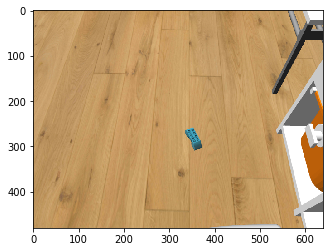

In [6]:
# 画像を取得します Get image data
image_data = rgbd.get_image()
# 取得した画像を表示してみます Display the image data
plt.imshow(image_data)

画像データは、480x640x3の3次元配列です。

The image data is a 480x640x3 three-dimensional array:

In [7]:
image_data.shape

(480, 640, 3)

最初の2次元は（y, x）のピクセルに対応します。最後の1次元はRGB形式のピクセル値です。

例えば以下の命令で左上のピクセルのRGB値にアクセスできます。

The first two dimensions correspond to pixels (y, x). The last dimension is the pixel values in RGB format.

For example, you can access the RGB value of the upper left pixel with the following command:

In [8]:
image_data[0][0]

array([202, 167, 114], dtype=uint8)

ポイントクラウド情報には、各ピクセルの3次元座標値が格納されています。

以下を実行することで、深度情報を表示することができます。

The point cloud information stores the 3D coordinate values of each pixel.

You can check the depth information using the following commands:

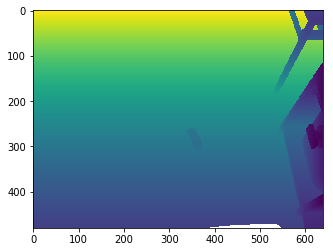

In [9]:
# ポイントクラウドを取得します Get point cloud information
points_data = rgbd.get_points()
# ポイントクラウドの深度情報を表示してみます Display the depth value of the point cloud information
plt.imshow(points_data['z'])

深度情報は、480x640の2次元配列です。

The depth information is a 480x640 two-dimensional array:

In [10]:
points_data['z'].shape

(480, 640)

画像データと同様に、以下の命令で左上のピクセル値にアクセスできます。単位はメートルです。

Similar to the image data, we can access the depth value in the upper left with the following command. The unit is meters:

In [11]:
points_data['z'][0][0]

1.5213813

## 色空間の変換と色抽出

## Color space conversion and color extraction

レゴブロックの色は「水色」なので、色を使ってレゴブロックを検出してみましょう。

「image_data」にはRGB形式で色のデータが格納されています。
RGB形式のデータをそのまま使ってもよいのですが、RGBからHSVに色空間を変換すると照明変化に頑健になることが知られています。

HSVは、色相(Hue)、彩度(Saturation)、明度(Value)によって色を表現します。今回は色相情報のみを利用してレゴブロックの水色を抽出します。

The color of the Lego block is "light blue", so let's use the color to detect the Lego block.

Color data is stored in RGB format in "image_data".
We can use the RGB data as is, but it is known that converting the color space from RGB to HSV makes it more robust against changes in lighting.

HSV expresses color by Hue, Saturation and Value. This time, we will extract the light blue of the Lego block using the hue channel:

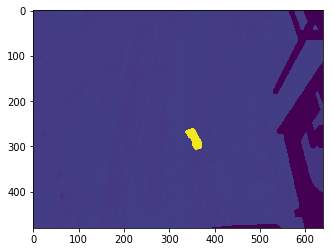

In [12]:
# 画像の色相の値を取得します Get hue channel
h_image = rgbd.get_h_image()
# 色相画像を表示してみます Display the hue channel
plt.imshow(h_image)

色相画像に対して適当な閾値を設定して、レゴブロックのみが抽出されるようにします。

Set an appropriate threshold for the hue image so that only the light blue Lego block is extracted:

In [13]:
from ipywidgets import interact

def f(lower = 0, upper = 255):
    yellow_region = (h_image > lower) & (h_image < upper)
    plt.imshow(yellow_region)

interact(f, lower=(0, 255, 5), upper=(0, 255, 5))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2xvd2VyJywgbWF4PTI1NSwgc3RlcD01KSwgSW50U2xpZGVyKHZhbHVlPTI1NSwgZGVzY3JpcHTigKY=


<function __main__.f>

閾値を下限130、上限140ぐらいに設定すると安定して抽出できるようです。

It seems that stable extraction can be achieved by setting the threshold to the lower limit of 130 and the upper limit of 140.

<div class="alert alert-block alert-info">
    <b>課題</b>
    <p>同様にバナナやリンゴを抽出してみましょう。</p>
    <p>以下を実行することで、バナナとリンゴを出現させることができます。</p>
</div>

<div class="alert alert-block alert-info">
    <b>Task</b>
    <p>Try to extract banana and apple as well.</p>
    <p>By entering the following commands, we can spawn banana and apple.</p>
</div>

In [14]:
put_object("banana", 0.6, 0.2, 0.0)

In [15]:
put_object("apple", 1.0, 0.0, 0.0)

## レゴブロックの位置の取得

## Get the position of the Lego block

レゴブロックを抽出できる色相画像の閾値を設定します。

Set the threshold of the hue image from which the light blue Lego block can be extracted:

In [16]:
rgbd.set_h(130, 140)

設定した閾値の色相画像を表示させてみましょう。

Let's display the configured threshold of the hue image:

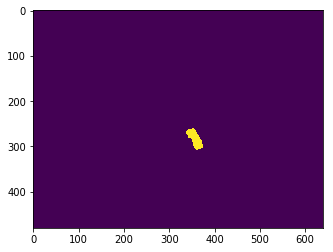

In [17]:
region = rgbd.get_region()
plt.imshow(region)

ポイントクラウド情報から、レゴブロックと考えられる領域のxyz座標の平均値を計算します。

レゴブロックのxyz座標が以下のように計算できました。

From the point cloud information, calculate the average value of the xyz coordinates of the area considered to be a Lego block.

The xyz coordinates of the Lego block can be calculated as follows:

In [18]:
rgbd.get_xyz()

[0.06549108, 0.079493605, 1.0166668]

このxyz値は、「head_rgbd_sensor_rgb_frame」基準座標、つまりRGBDカメラ座標上での値です。

This xyz value is the value in the "head_rgbd_sensor_rgb_frame" reference coordinates, that is the RGBD camera coordinates.

## レゴブロックの座標の出力

## Display the Lego block coordinates

出力される座標の名前を`lego`にセットしましょう。

Let's set the name of the output coordinates to `lego`.

In [19]:
rgbd.set_coordinate_name("lego")

新しいポイントクラウド情報が入力されるたびにbananaの座標情報が出力されます。

「TF」の「Frames」から`lego`を選択してが正しくpublishされているか確認しましょう。

![title](./imgs/5_lego_tf.png)

The coordinate information of banana is updated every time on new point cloud information input.

Select `lego` from "Frames" of "TF" and check if it is published correctly:

![title](./imgs/5_lego_tf.png)

座標情報はPythonでもアクセスできます。

例えば、絶対座標（map）上での`lego`の位置(x, y)は以下のように取得できます。

Coordinate information can also be accessed in Python.

For example, the position (x, y) of `lego` on the absolute coordinates (=map) can be obtained as follows:

In [20]:
trans = get_relative_coordinate("map", "lego")
x = trans.translation.x
y = trans.translation.y
x, y

(0.638684028721533, -0.026736438299832115)

`lego`は、絶対座標上で約（x, y）=（0.6, 0.0）の座標に置かれているようです。

`lego` seems to be placed at about (x, y) = (0.6, 0.0) position in absolute coordinates.

## 認識結果を用いた制御

## Control using recognition results

以上の認識器を用いて、HSRにレゴブロックを拾わせてみましょう。

前章の関数`move_wholebody_ik`に認識結果のx, yを引数として与え、逆運動学によってHSRを制御します。

Let's make the HSR pick up the light blue Lego block using the above recognizer.

The function `move_wholebody_ik` in the previous section is given the recognition result x and y as arguments, and the HSR is controlled by inverse kinematics:

In [21]:
# ハンドを開く Open the hand
move_hand(1)
# 逆運動学を使ってHSRの手先を動かします Move the end effector by using inverse kinematics
move_wholebody_ik(x, y, 0.1, 180, 0, 0)
# ハンドを閉じる Close the hand
move_hand(0)
# アームを初期姿勢に戻す Move the hand to the initial position
move_arm_init()

True

<div class="alert alert-block alert-info">
    <b>課題</b>
    <p>レゴブロックを出現させる位置を変えても上手く拾えるか試してみましょう。</p>
</div>

<div class="alert alert-block alert-info">
    <b>Task</b>
    <p>Check that picking up the light blue Lego block will succeed even if we change its position.</p>
</div>

In [22]:
# レゴブロックを削除 Delete Lego block
delete_object("e_lego_duplo")

In [23]:
# レゴブロックを配置 Place the Lego block at the different position
put_object("e_lego_duplo", 0.6, 0.2, 0.0)

In [ ]:
# 自分で考えてみましょう。この下に入力できます。 Write your code here:
